In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [5]:
training_data = pd.read_csv('Train.csv',delimiter = ',')
test_data = pd.read_csv('Test.csv')
print(len(test_data))

5035


In [6]:
training_data.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


# Data Conversion, Evaluation and scaling

In [533]:
#Setup dataset matrix and replace nan values with -9999
loc = training_data['location']
print(loc[5])
loc_data = []
for i in range(len(loc)):
    lst1 = loc[i]
    if lst1 == 'A':
        loc_data.append(1)
    elif lst1 == 'B':
        loc_data.append(2)
    elif lst1 == 'C':
        loc_data.append(3)
    elif lst1 == 'D':
        loc_data.append(4)
    else:
        loc_data.append(5)
loc_data = np.array(loc_data)
temp = training_data['temp']
precip = training_data['precip']
rel_humidity = training_data['rel_humidity']
wind_dir = training_data['wind_dir']
wind_spd = training_data['wind_spd']
atmos_press = training_data['atmos_press']

def data_conversion(data,dim):
    mat = []
    for i in range(len(data)):
        lst = data[i]
        lst = lst.split(',')
        for j in range(len(lst)):
            if lst[j]=='nan':
                lst[j] = '-9999'
        lst = [float(k) for k in lst]
        lst = np.array(lst)
        mat.append(lst)
    mat = np.reshape(mat,(dim[0],dim[1]))
    return mat

new_loc = []
for i in range(len(loc_data)):
    arr = np.ones(121)*loc_data[i]
    new_loc.append(arr)
new_loc = np.array(new_loc)
print(new_loc.shape)

temp_data = data_conversion(temp,[15539,121])
precip_data = data_conversion(precip,[15539,121])
rel_humidity_data = data_conversion(rel_humidity,[15539,121])
wind_dir_data = data_conversion(wind_dir,[15539,121])
wind_spd_data = data_conversion(wind_spd,[15539,121])
atmos_press_data = data_conversion(atmos_press,[15539,121])

data_set = np.array([new_loc,temp_data,precip_data,rel_humidity_data,wind_dir_data,wind_spd_data,atmos_press_data])
data_set = data_set.transpose(1,0,2)
print(data_set.shape)

target = training_data['target']
target = [float(k) for k in target]


E
(15539, 121)
(15539, 7, 121)


In [534]:
#Look for samples with more than 30% missing values
del_indexes = []
for i in tqdm(range(len(data_set))):
    num = np.count_nonzero(data_set[i,:,:] == -9999)
    percentage_missing = num/(121*6)
    if percentage_missing > 0.3:
        del_indexes.append(i)
print(len(del_indexes))

100%|██████████| 15539/15539 [00:00<00:00, 141345.88it/s]

1539


In [535]:
# Delete samples with more than 30% missing values
data_set_reduced = np.delete(data_set,del_indexes,axis = 0)
target_reduced = np.delete(target,del_indexes)
target_reduced = np.array(target_reduced)
print(data_set_reduced.shape)
print(target_reduced.shape)

(14000, 7, 121)
(14000,)


In [536]:
#Setup  test dataset matrix and replace nan values with -9999
loct = test_data['location']
print(loct[5])
loc_datat = []
for i in range(len(loct)):
    lst1 = loct[i]
    if lst1 == 'A':
        loc_datat.append(1)
    elif lst1 == 'B':
        loc_datat.append(2)
    elif lst1 == 'C':
        loc_datat.append(3)
    elif lst1 == 'D':
        loc_datat.append(4)
    else:
        loc_datat.append(5)
loc_datat = np.array(loc_datat)
print(loc_datat.shape)
new_loct = []
for i in range(len(loc_datat)):
    arr = np.ones(121)*loc_datat[i]
    new_loct.append(arr)
new_loct = np.array(new_loct)
print(new_loct.shape)


tempt = test_data['temp']
precipt = test_data['precip']
rel_humidityt = test_data['rel_humidity']
wind_dirt = test_data['wind_dir']
wind_spdt = test_data['wind_spd']
atmos_presst = test_data['atmos_press']

def data_conversion(data,dim):
    mat = []
    for i in range(len(data)):
        lst = data[i]
        lst = lst.split(',')
        for j in range(len(lst)):
            if lst[j]=='nan':
                lst[j] = '-9999'
        lst = [float(k) for k in lst]
        lst = np.array(lst)
        mat.append(lst)
    mat = np.reshape(mat,(dim[0],dim[1]))
    return mat


temp_datat = data_conversion(tempt,[5035,121])
precip_datat = data_conversion(precipt,[5035,121])
rel_humidity_datat = data_conversion(rel_humidityt,[5035,121])
wind_dir_datat = data_conversion(wind_dirt,[5035,121])
wind_spd_datat = data_conversion(wind_spdt,[5035,121])
atmos_press_datat = data_conversion(atmos_presst,[5035,121])

data_set_test = np.array([new_loct,temp_datat,precip_datat,rel_humidity_datat,wind_dir_datat,wind_spd_datat,atmos_press_datat])
data_set_test = data_set_test.transpose(1,0,2)
print(data_set_test.shape)


D
(5035,)
(5035, 121)
(5035, 7, 121)


In [537]:
# Scaling the data except the nan values

def remove_values_from_list(data):
    data_flatten = np.ravel(data)
    data_eval = np.array([value for value in data_flatten if value != -9999])
    return np.max(data_eval),np.min(data_eval)
def scaling(data_train1,data_test1):
    maxval,minval = remove_values_from_list(data_train1)
    diff = maxval - minval
    m = 4/diff
    c = 5-m*maxval
    data_train1 = m*data_train1 + c
    data_test1 = m*data_test1 + c
    valnan =m*-9999 + c
    return data_train1,data_test1,valnan

def complete_scaling(data_train,data_test):
    data_train_scaled = data_train
    data_test_scaled = data_test
    for j in range(len(data_train_scaled[0,:,:])):
        data_train_scaled[:,j,:],data_test_scaled[:,j,:],valnan = scaling(data_train_scaled[:,j,:],data_test_scaled[:,j,:])
#         for i in range(len(data_train_scaled)):
#             for k in range(len(data_train_scaled[0,0,:])):
#                 if data_train_scaled[i,j,k]== valnan:
#                     data_train_scaled[i,j,k] = np.mean([data_train_scaled[i,j,k-1],data_train_scaled[i,j,k-2]])
#         for i in range(len(data_test_scaled)):
#             for k in range(len(data_test_scaled[0,0,:])):
#                 if data_test_scaled[i,j,k]== valnan:
#                     data_test_scaled[i,j,k] = np.mean([data_test_scaled[i,j,k-1],data_test_scaled[i,j,k-2]])
        data_train_scaled[:,j,:] = np.where(data_train_scaled[:,j,:]==valnan,-9999, data_train_scaled[:,j,:])
        data_test_scaled[:,j,:] = np.where(data_test_scaled[:,j,:]==valnan,-9999, data_test_scaled[:,j,:])
    return data_train_scaled,data_test_scaled
            

data_set_train_scaled,data_set_test_scaled = complete_scaling(data_set_reduced,data_set_test)
data_set_test_scaled = np.reshape(data_set_test_scaled,(5035,7,121,1))
data_set_train_scaled = np.reshape(data_set_train_scaled,(14000,7,121,1))
print(data_set_test_scaled.shape)
print(data_set_train_scaled.shape)

(5035, 7, 121, 1)
(14000, 7, 121, 1)


# Data splitting

In [538]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data_set_train_scaled,target_reduced,test_size=0.2)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(11200, 7, 121, 1)
(2800, 7, 121, 1)
(11200,)
(2800,)


# Model 1: CNN

In [539]:
from tensorflow.keras import datasets, layers, models

In [549]:
#####Build CNN architecture
##### Best so far
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 5), activation='relu', input_shape=(7,121,1)))
model.add(layers.Conv2D(64, (2, 10), activation='relu'))
model.add(layers.MaxPooling2D((2, 6)))
model.add(layers.Conv2D(128, (2, 15), activation='relu'))
model.summary()

# # Attempt
# model = models.Sequential()
# model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(7,121,1)))
# model.add(layers.Conv2D(64, (2, 10), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (2, 20),padding = 'same', activation='relu'))
# model.add(layers.Conv2D(128, (2, 30), activation='relu'))
# model.add(layers.MaxPooling2D((1, 5)))
# model.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 6, 117, 32)        352       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 5, 108, 64)        41024     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 2, 18, 64)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 1, 4, 128)         245888    
Total params: 287,264
Trainable params: 287,264
Non-trainable params: 0
_________________________________________________________________


In [550]:
#Add normal NN to end for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 6, 117, 32)        352       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 5, 108, 64)        41024     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 2, 18, 64)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 1, 4, 128)         245888    
_________________________________________________________________
flatten_28 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_117 (Dense)            (None, 1)               

In [551]:
#Define optimiser algorithm and loss metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])
#Train the model
history = model.fit(xtrain, ytrain,batch_size = 32, epochs=15,
                    validation_data=(xtest, ytest))

Train on 11200 samples, validate on 2800 samples
Epoch 1/15
11200/11200 [==============================] - 42s 4ms/sample - loss: 4196.9326 - acc: 0.0000e+00 - root_mean_squared_error: 64.7837 - val_loss: 1739.0062 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.7014
Epoch 2/15
11200/11200 [==============================] - 35s 3ms/sample - loss: 1699.1993 - acc: 0.0000e+00 - root_mean_squared_error: 41.2213 - val_loss: 1634.1751 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.4249
Epoch 3/15
11200/11200 [==============================] - 36s 3ms/sample - loss: 1626.6029 - acc: 0.0000e+00 - root_mean_squared_error: 40.3312 - val_loss: 1612.2788 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.1532
Epoch 4/15
11200/11200 [==============================] - 35s 3ms/sample - loss: 1584.6291 - acc: 0.0000e+00 - root_mean_squared_error: 39.8074 - val_loss: 1519.5801 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 38.9818- root_mea
Epoch 5/15
11200/11200 [=========

<IPython.core.display.Javascript object>


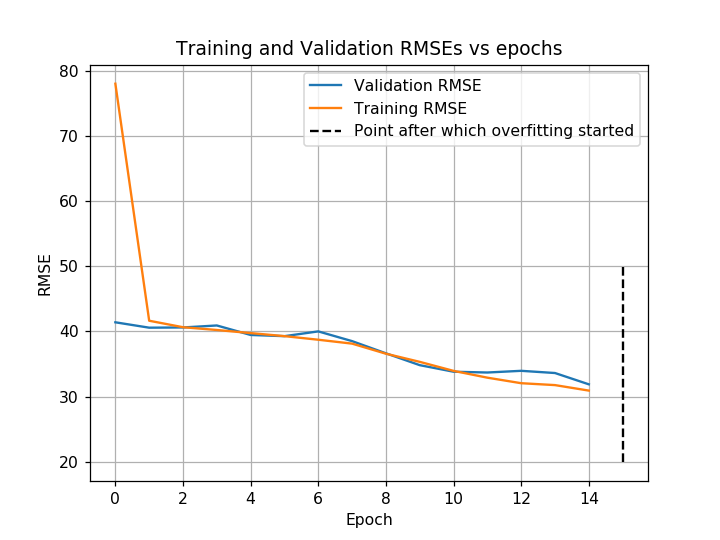

In [546]:
%matplotlib notebook
plt.figure(1)
plt.title('Training and Validation RMSEs vs epochs')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.ylabel('RMSE')
plt.plot([15,15],[20,50],'k--',label = 'Point after which overfitting started')
plt.legend(loc = 'best')
plt.grid()

### Testing data set

In [547]:
values = model.predict(data_set_test_scaled)
# values = np.array([int(i) for i in values])

In [548]:
df = pd.DataFrame(values)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)

# Model 2: LSTM Model

In [563]:
data_set_train_scaled = np.reshape(data_set_train_scaled,(14000,7,121))
data_set_test_scaled = np.reshape(data_set_test_scaled,(5035,7,121))
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data_set_train_scaled,target_reduced,test_size=0.2)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(11200, 7, 121)
(2800, 7, 121)
(11200,)
(2800,)


In [564]:
#Best so far
# lstm_model = models.Sequential()
# lstm_model.add(layers.LSTM(500,input_shape = (6,121)))
# lstm_model.add(layers.Dense(1))
# lstm_model.summary()
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(5,input_shape = (7,121)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))
lstm_model.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 5)                 2540      
_________________________________________________________________
dropout_24 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 6         
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________


In [565]:

lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history_lstm = lstm_model.fit(xtrain, ytrain,batch_size = 280, epochs=1000,
                    validation_data=(xtest, ytest))

Train on 11200 samples, validate on 2800 samples
Epoch 1/1000
11200/11200 [==============================] - 5s 433us/sample - loss: 5017.8144 - acc: 0.0000e+00 - root_mean_squared_error: 70.8365 - val_loss: 5017.5215 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 70.8345
Epoch 2/1000
11200/11200 [==============================] - 1s 61us/sample - loss: 4962.8013 - acc: 0.0000e+00 - root_mean_squared_error: 70.4472 - val_loss: 4995.7246 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 70.6804
Epoch 3/1000
11200/11200 [==============================] - 1s 61us/sample - loss: 4941.5801 - acc: 0.0000e+00 - root_mean_squared_error: 70.2964 - val_loss: 4975.2730 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 70.5356
Epoch 4/1000
11200/11200 [==============================] - 1s 61us/sample - loss: 4921.0199 - acc: 0.0000e+00 - root_mean_squared_error: 70.1500 - val_loss: 4953.5497 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 70.3815
Epoch 5/1000
11200/11200 [========

11200/11200 [==============================] - 1s 72us/sample - loss: 4329.9772 - acc: 0.0000e+00 - root_mean_squared_error: 65.8026 - val_loss: 4355.5554 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 65.9966
Epoch 37/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 4318.3195 - acc: 0.0000e+00 - root_mean_squared_error: 65.7139 - val_loss: 4338.0530 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 65.8639
Epoch 38/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 4301.2656 - acc: 0.0000e+00 - root_mean_squared_error: 65.5840 - val_loss: 4321.1253 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 65.7353
Epoch 39/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 4282.9475 - acc: 0.0000e+00 - root_mean_squared_error: 65.4442 - val_loss: 4304.5516 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 65.6091
Epoch 40/1000
11200/11200 [==============================] - 1s 79us/sample - loss: 4268.1859 

Epoch 72/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 3574.0336 - acc: 0.0000e+00 - root_mean_squared_error: 59.7832 - val_loss: 3571.4517 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 59.7616
Epoch 73/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 3554.4197 - acc: 0.0000e+00 - root_mean_squared_error: 59.6190 - val_loss: 3553.5914 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 59.6120
Epoch 74/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 3540.2021 - acc: 0.0000e+00 - root_mean_squared_error: 59.4996 - val_loss: 3535.2433 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 59.4579
Epoch 75/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 3514.7207 - acc: 0.0000e+00 - root_mean_squared_error: 59.2851 - val_loss: 3517.4354 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 59.3080
Epoch 76/1000
11200/11200 [==============================] - 1s 72us/sample - lo

11200/11200 [==============================] - 1s 73us/sample - loss: 3080.7315 - acc: 0.0000e+00 - root_mean_squared_error: 55.5043 - val_loss: 3054.6949 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 55.2693
Epoch 108/1000
11200/11200 [==============================] - 1s 74us/sample - loss: 3059.9277 - acc: 0.0000e+00 - root_mean_squared_error: 55.3166 - val_loss: 3040.8807 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 55.1442
Epoch 109/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 3057.1772 - acc: 0.0000e+00 - root_mean_squared_error: 55.2917 - val_loss: 3028.3268 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 55.0302
Epoch 110/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 3036.9343 - acc: 0.0000e+00 - root_mean_squared_error: 55.1084 - val_loss: 3015.2652 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 54.9114
Epoch 111/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 3021.4

11200/11200 [==============================] - 1s 72us/sample - loss: 2699.3702 - acc: 0.0000e+00 - root_mean_squared_error: 51.9555 - val_loss: 2662.6389 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 51.6008
Epoch 143/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2688.1363 - acc: 0.0000e+00 - root_mean_squared_error: 51.8472 - val_loss: 2653.0835 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 51.5081
Epoch 144/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2686.2461 - acc: 0.0000e+00 - root_mean_squared_error: 51.8290 - val_loss: 2643.2899 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 51.4129
Epoch 145/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 2668.3675 - acc: 0.0000e+00 - root_mean_squared_error: 51.6562 - val_loss: 2633.9968 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 51.3225
Epoch 146/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2657.0

11200/11200 [==============================] - 1s 72us/sample - loss: 2426.4543 - acc: 0.0000e+00 - root_mean_squared_error: 49.2591 - val_loss: 2371.0258 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 48.6932
Epoch 178/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2423.4304 - acc: 0.0000e+00 - root_mean_squared_error: 49.2284 - val_loss: 2364.0727 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 48.6217
Epoch 179/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 2410.1448 - acc: 0.0000e+00 - root_mean_squared_error: 49.0932 - val_loss: 2357.3833 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 48.5529
Epoch 180/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 2406.3728 - acc: 0.0000e+00 - root_mean_squared_error: 49.0548 - val_loss: 2351.0918 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 48.4881
Epoch 181/1000
11200/11200 [==============================] - 1s 74us/sample - loss: 2402.7

11200/11200 [==============================] - 1s 71us/sample - loss: 2257.2187 - acc: 0.0000e+00 - root_mean_squared_error: 47.5102 - val_loss: 2176.1651 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.6494
Epoch 213/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2251.2286 - acc: 0.0000e+00 - root_mean_squared_error: 47.4471 - val_loss: 2171.7883 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.6025
Epoch 214/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2237.8010 - acc: 0.0000e+00 - root_mean_squared_error: 47.3054 - val_loss: 2167.2443 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.5537
Epoch 215/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2239.4739 - acc: 0.0000e+00 - root_mean_squared_error: 47.3231 - val_loss: 2163.0248 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.5083
Epoch 216/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2225.4

11200/11200 [==============================] - 1s 88us/sample - loss: 2150.1257 - acc: 0.0000e+00 - root_mean_squared_error: 46.3694 - val_loss: 2056.2513 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 45.3459
Epoch 248/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2144.5277 - acc: 0.0000e+00 - root_mean_squared_error: 46.3090 - val_loss: 2053.9974 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 45.3210
Epoch 249/1000
11200/11200 [==============================] - 1s 77us/sample - loss: 2142.4517 - acc: 0.0000e+00 - root_mean_squared_error: 46.2866 - val_loss: 2051.1252 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 45.2893
Epoch 250/1000
11200/11200 [==============================] - 1s 79us/sample - loss: 2154.3778 - acc: 0.0000e+00 - root_mean_squared_error: 46.4153 - val_loss: 2051.8237 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 45.2971
Epoch 251/1000
11200/11200 [==============================] - 1s 80us/sample - loss: 2135.0

11200/11200 [==============================] - 1s 71us/sample - loss: 2111.1693 - acc: 0.0000e+00 - root_mean_squared_error: 45.9475 - val_loss: 2000.0999 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.7225
Epoch 283/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2100.4560 - acc: 0.0000e+00 - root_mean_squared_error: 45.8307 - val_loss: 1999.3259 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.7138
Epoch 284/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2086.8576 - acc: 0.0000e+00 - root_mean_squared_error: 45.6821 - val_loss: 1997.9586 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.6985
Epoch 285/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 2108.2370 - acc: 0.0000e+00 - root_mean_squared_error: 45.9155 - val_loss: 1996.7418 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.6849
Epoch 286/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2099.0

11200/11200 [==============================] - 1s 74us/sample - loss: 2076.7551 - acc: 0.0000e+00 - root_mean_squared_error: 45.5714 - val_loss: 1971.9295 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.4064
Epoch 318/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2075.9291 - acc: 0.0000e+00 - root_mean_squared_error: 45.5624 - val_loss: 1971.3656 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.4001
Epoch 319/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 2084.2684 - acc: 0.0000e+00 - root_mean_squared_error: 45.6538 - val_loss: 1971.5192 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.4018
Epoch 320/1000
11200/11200 [==============================] - 1s 83us/sample - loss: 2074.4400 - acc: 0.0000e+00 - root_mean_squared_error: 45.5460 - val_loss: 1969.7319 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.3817
Epoch 321/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 2080.3

11200/11200 [==============================] - 1s 71us/sample - loss: 2077.3068 - acc: 0.0000e+00 - root_mean_squared_error: 45.5775 - val_loss: 1952.7208 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.1896
Epoch 353/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2072.3581 - acc: 0.0000e+00 - root_mean_squared_error: 45.5232 - val_loss: 1954.3843 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.2084
Epoch 354/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2073.5603 - acc: 0.0000e+00 - root_mean_squared_error: 45.5364 - val_loss: 1951.7911 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.1791
Epoch 355/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2078.3124 - acc: 0.0000e+00 - root_mean_squared_error: 45.5885 - val_loss: 1952.9251 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 44.1919
Epoch 356/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2076.0

11200/11200 [==============================] - 1s 74us/sample - loss: 2059.3068 - acc: 0.0000e+00 - root_mean_squared_error: 45.3796 - val_loss: 1935.2870 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.9919
Epoch 388/1000
11200/11200 [==============================] - 1s 70us/sample - loss: 2057.3595 - acc: 0.0000e+00 - root_mean_squared_error: 45.3581 - val_loss: 1935.2258 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.9912
Epoch 389/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2049.0867 - acc: 0.0000e+00 - root_mean_squared_error: 45.2668 - val_loss: 1935.6088 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.9956
Epoch 390/1000
11200/11200 [==============================] - 1s 70us/sample - loss: 2049.2758 - acc: 0.0000e+00 - root_mean_squared_error: 45.2689 - val_loss: 1934.1067 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.9785
Epoch 391/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2044.8

11200/11200 [==============================] - 1s 72us/sample - loss: 2013.8373 - acc: 0.0000e+00 - root_mean_squared_error: 44.8758 - val_loss: 1898.3214 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.5697
Epoch 423/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2012.2435 - acc: 0.0000e+00 - root_mean_squared_error: 44.8580 - val_loss: 1897.7504 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.5632
Epoch 424/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2003.6994 - acc: 0.0000e+00 - root_mean_squared_error: 44.7627 - val_loss: 1895.5091 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.5374
Epoch 425/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 2012.2942 - acc: 0.0000e+00 - root_mean_squared_error: 44.8586 - val_loss: 1892.8434 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.5068
Epoch 426/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 2002.4

11200/11200 [==============================] - 1s 72us/sample - loss: 1960.9659 - acc: 0.0000e+00 - root_mean_squared_error: 44.2828 - val_loss: 1860.0325 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.1281
Epoch 458/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1968.4791 - acc: 0.0000e+00 - root_mean_squared_error: 44.3675 - val_loss: 1858.0332 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.1049
Epoch 459/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 1971.2210 - acc: 0.0000e+00 - root_mean_squared_error: 44.3984 - val_loss: 1856.2124 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.0838
Epoch 460/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1966.4798 - acc: 0.0000e+00 - root_mean_squared_error: 44.3450 - val_loss: 1856.0475 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 43.0819
Epoch 461/1000
11200/11200 [==============================] - 1s 74us/sample - loss: 1962.6

11200/11200 [==============================] - 1s 74us/sample - loss: 1930.9018 - acc: 0.0000e+00 - root_mean_squared_error: 43.9420 - val_loss: 1830.3965 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.7831
Epoch 493/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1934.0097 - acc: 0.0000e+00 - root_mean_squared_error: 43.9774 - val_loss: 1823.3938 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.7012
Epoch 494/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1931.4910 - acc: 0.0000e+00 - root_mean_squared_error: 43.9487 - val_loss: 1821.8947 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.6837
Epoch 495/1000
11200/11200 [==============================] - 1s 77us/sample - loss: 1934.2333 - acc: 0.0000e+00 - root_mean_squared_error: 43.9799 - val_loss: 1821.2271 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.6758
Epoch 496/1000
11200/11200 [==============================] - 1s 81us/sample - loss: 1933.1

11200/11200 [==============================] - 1s 73us/sample - loss: 1901.6022 - acc: 0.0000e+00 - root_mean_squared_error: 43.6074 - val_loss: 1785.0690 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.2501
Epoch 528/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1894.0043 - acc: 0.0000e+00 - root_mean_squared_error: 43.5202 - val_loss: 1781.0006 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.2019
Epoch 529/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1895.7743 - acc: 0.0000e+00 - root_mean_squared_error: 43.5405 - val_loss: 1783.1359 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.2272
Epoch 530/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1894.1142 - acc: 0.0000e+00 - root_mean_squared_error: 43.5214 - val_loss: 1778.1414 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 42.1680
Epoch 531/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1890.9

11200/11200 [==============================] - 1s 71us/sample - loss: 1877.5059 - acc: 0.0000e+00 - root_mean_squared_error: 43.3302 - val_loss: 1759.6751 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.9485
Epoch 563/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1887.2646 - acc: 0.0000e+00 - root_mean_squared_error: 43.4427 - val_loss: 1761.9514 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.9756
Epoch 564/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1868.3889 - acc: 0.0000e+00 - root_mean_squared_error: 43.2249 - val_loss: 1761.2612 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.9674
Epoch 565/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1871.9431 - acc: 0.0000e+00 - root_mean_squared_error: 43.2660 - val_loss: 1761.0496 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.9649
Epoch 566/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1875.8

11200/11200 [==============================] - 1s 73us/sample - loss: 1872.3974 - acc: 0.0000e+00 - root_mean_squared_error: 43.2712 - val_loss: 1747.4213 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.8022
Epoch 598/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1845.4781 - acc: 0.0000e+00 - root_mean_squared_error: 42.9590 - val_loss: 1743.7171 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.7578
Epoch 599/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1853.0199 - acc: 0.0000e+00 - root_mean_squared_error: 43.0467 - val_loss: 1744.4544 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.7667
Epoch 600/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1843.5421 - acc: 0.0000e+00 - root_mean_squared_error: 42.9365 - val_loss: 1742.7931 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.7468
Epoch 601/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1852.7

11200/11200 [==============================] - 1s 72us/sample - loss: 1842.3210 - acc: 0.0000e+00 - root_mean_squared_error: 42.9223 - val_loss: 1726.2344 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.5480
Epoch 633/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 1835.7050 - acc: 0.0000e+00 - root_mean_squared_error: 42.8451 - val_loss: 1726.0287 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.5455
Epoch 634/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1837.1656 - acc: 0.0000e+00 - root_mean_squared_error: 42.8622 - val_loss: 1729.4406 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.5865
Epoch 635/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1842.7858 - acc: 0.0000e+00 - root_mean_squared_error: 42.9277 - val_loss: 1721.9258 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.4961
Epoch 636/1000
11200/11200 [==============================] - 1s 70us/sample - loss: 1833.8

11200/11200 [==============================] - 1s 72us/sample - loss: 1827.7572 - acc: 0.0000e+00 - root_mean_squared_error: 42.7523 - val_loss: 1710.4984 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3582
Epoch 668/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1826.5352 - acc: 0.0000e+00 - root_mean_squared_error: 42.7380 - val_loss: 1712.8580 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3867
Epoch 669/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1826.4366 - acc: 0.0000e+00 - root_mean_squared_error: 42.7368 - val_loss: 1709.5398 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3466
Epoch 670/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1817.9468 - acc: 0.0000e+00 - root_mean_squared_error: 42.6374 - val_loss: 1709.6645 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3481
Epoch 671/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1824.6

11200/11200 [==============================] - 1s 73us/sample - loss: 1809.0610 - acc: 0.0000e+00 - root_mean_squared_error: 42.5331 - val_loss: 1701.2250 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2459
Epoch 703/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1806.1272 - acc: 0.0000e+00 - root_mean_squared_error: 42.4986 - val_loss: 1699.4170 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2240
Epoch 704/1000
11200/11200 [==============================] - 1s 74us/sample - loss: 1812.4027 - acc: 0.0000e+00 - root_mean_squared_error: 42.5723 - val_loss: 1701.0006 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2432
Epoch 705/1000
11200/11200 [==============================] - 1s 70us/sample - loss: 1810.3059 - acc: 0.0000e+00 - root_mean_squared_error: 42.5477 - val_loss: 1700.6171 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2385
Epoch 706/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1805.6

11200/11200 [==============================] - 1s 77us/sample - loss: 1799.2774 - acc: 0.0000e+00 - root_mean_squared_error: 42.4179 - val_loss: 1692.9611 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.1456
Epoch 738/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1797.7410 - acc: 0.0000e+00 - root_mean_squared_error: 42.3998 - val_loss: 1692.3442 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.1381
Epoch 739/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1798.1200 - acc: 0.0000e+00 - root_mean_squared_error: 42.4043 - val_loss: 1689.8447 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.1077
Epoch 740/1000
11200/11200 [==============================] - 1s 88us/sample - loss: 1787.9947 - acc: 0.0000e+00 - root_mean_squared_error: 42.2847 - val_loss: 1687.2275 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.0759
Epoch 741/1000
11200/11200 [==============================] - 1s 79us/sample - loss: 1805.1

11200/11200 [==============================] - 1s 77us/sample - loss: 1802.9520 - acc: 0.0000e+00 - root_mean_squared_error: 42.4612 - val_loss: 1661.2756 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7587
Epoch 773/1000
11200/11200 [==============================] - 1s 78us/sample - loss: 1771.6278 - acc: 0.0000e+00 - root_mean_squared_error: 42.0907 - val_loss: 1660.7983 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7529
Epoch 774/1000
11200/11200 [==============================] - 1s 70us/sample - loss: 1758.4290 - acc: 0.0000e+00 - root_mean_squared_error: 41.9336 - val_loss: 1658.7888 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7282
Epoch 775/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1787.5751 - acc: 0.0000e+00 - root_mean_squared_error: 42.2797 - val_loss: 1661.0650 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7562
Epoch 776/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1755.2

11200/11200 [==============================] - 1s 73us/sample - loss: 1755.8386 - acc: 0.0000e+00 - root_mean_squared_error: 41.9027 - val_loss: 1638.3776 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.4769
Epoch 808/1000
11200/11200 [==============================] - 1s 84us/sample - loss: 1756.9686 - acc: 0.0000e+00 - root_mean_squared_error: 41.9162 - val_loss: 1640.4234 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.5021
Epoch 809/1000
11200/11200 [==============================] - 1s 82us/sample - loss: 1758.2285 - acc: 0.0000e+00 - root_mean_squared_error: 41.9312 - val_loss: 1640.9114 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.5082
Epoch 810/1000
11200/11200 [==============================] - 1s 78us/sample - loss: 1744.4683 - acc: 0.0000e+00 - root_mean_squared_error: 41.7668 - val_loss: 1645.3554 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.5630
Epoch 811/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1736.5

11200/11200 [==============================] - 1s 72us/sample - loss: 1711.8804 - acc: 0.0000e+00 - root_mean_squared_error: 41.3749 - val_loss: 1622.6354 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.2819
Epoch 843/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 1737.6645 - acc: 0.0000e+00 - root_mean_squared_error: 41.6853 - val_loss: 1625.5652 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.3183
Epoch 844/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 1738.5678 - acc: 0.0000e+00 - root_mean_squared_error: 41.6961 - val_loss: 1621.9710 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.2737
Epoch 845/1000
11200/11200 [==============================] - 1s 75us/sample - loss: 1742.2886 - acc: 0.0000e+00 - root_mean_squared_error: 41.7407 - val_loss: 1619.3579 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.2412
Epoch 846/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 1734.1

11200/11200 [==============================] - 1s 74us/sample - loss: 1735.9875 - acc: 0.0000e+00 - root_mean_squared_error: 41.6652 - val_loss: 1611.7131 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.1461
Epoch 878/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1726.8396 - acc: 0.0000e+00 - root_mean_squared_error: 41.5553 - val_loss: 1618.8591 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.2351
Epoch 879/1000
11200/11200 [==============================] - 1s 77us/sample - loss: 1717.4430 - acc: 0.0000e+00 - root_mean_squared_error: 41.4420 - val_loss: 1619.4892 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.2429
Epoch 880/1000
11200/11200 [==============================] - 1s 80us/sample - loss: 1707.6163 - acc: 0.0000e+00 - root_mean_squared_error: 41.3233 - val_loss: 1613.9843 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.1744
Epoch 881/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 1714.5

11200/11200 [==============================] - 1s 71us/sample - loss: 1696.5682 - acc: 0.0000e+00 - root_mean_squared_error: 41.1894 - val_loss: 1605.2864 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.0660
Epoch 913/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1701.6874 - acc: 0.0000e+00 - root_mean_squared_error: 41.2515 - val_loss: 1600.2412 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.0030
Epoch 914/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1703.7191 - acc: 0.0000e+00 - root_mean_squared_error: 41.2761 - val_loss: 1603.6995 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.0462
Epoch 915/1000
11200/11200 [==============================] - 1s 74us/sample - loss: 1722.5531 - acc: 0.0000e+00 - root_mean_squared_error: 41.5037 - val_loss: 1598.6291 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.9829
Epoch 916/1000
11200/11200 [==============================] - 1s 76us/sample - loss: 1708.9

11200/11200 [==============================] - 1s 72us/sample - loss: 1705.1279 - acc: 0.0000e+00 - root_mean_squared_error: 41.2932 - val_loss: 1599.2627 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.9908
Epoch 948/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1694.5384 - acc: 0.0000e+00 - root_mean_squared_error: 41.1648 - val_loss: 1591.1665 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8894
Epoch 949/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1699.9031 - acc: 0.0000e+00 - root_mean_squared_error: 41.2299 - val_loss: 1590.2578 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8780
Epoch 950/1000
11200/11200 [==============================] - 1s 73us/sample - loss: 1692.0961 - acc: 0.0000e+00 - root_mean_squared_error: 41.1351 - val_loss: 1590.0176 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8750
Epoch 951/1000
11200/11200 [==============================] - 1s 81us/sample - loss: 1693.1

11200/11200 [==============================] - 1s 72us/sample - loss: 1690.3904 - acc: 0.0000e+00 - root_mean_squared_error: 41.1144 - val_loss: 1586.2570 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8278
Epoch 983/1000
11200/11200 [==============================] - 1s 71us/sample - loss: 1708.7958 - acc: 0.0000e+00 - root_mean_squared_error: 41.3376 - val_loss: 1591.4572 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8931
Epoch 984/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1685.1287 - acc: 0.0000e+00 - root_mean_squared_error: 41.0503 - val_loss: 1587.1430 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.8390
Epoch 985/1000
11200/11200 [==============================] - 1s 72us/sample - loss: 1680.7604 - acc: 0.0000e+00 - root_mean_squared_error: 40.9971 - val_loss: 1582.9617 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 39.7865
Epoch 986/1000
11200/11200 [==============================] - 1s 80us/sample - loss: 1687.6

<IPython.core.display.Javascript object>


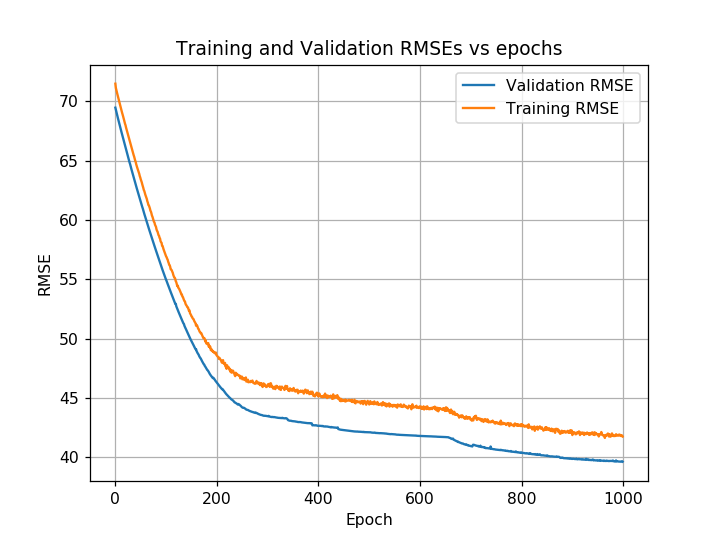

In [562]:
plt.figure(2)
plt.plot(history_lstm.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.plot(history_lstm.history['root_mean_squared_error'], label='Training RMSE')
#plt.plot([600,600],[45,50],'k--',label = 'Point after which overfitting started')
plt.title('Training and Validation RMSEs vs epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc = 'best')
plt.grid()

In [566]:

values_lstm = lstm_model.predict(data_set_test_scaled)
df = pd.DataFrame(values_lstm)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)

# Model 3: Multilayer LSTM

In [582]:
data_set_train_scaled = np.reshape(data_set_train_scaled,(14000,7,121))
data_set_test_scaled = np.reshape(data_set_test_scaled,(5035,7,121))
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data_set_train_scaled,target_reduced,test_size=0.2)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(11200, 7, 121)
(2800, 7, 121)
(11200,)
(2800,)


In [583]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(1,return_sequences=True,input_shape = (7,121)))
lstm_model.add(layers.LSTM(1,return_sequences=True))
lstm_model.add(layers.LSTM(20))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))
lstm_model.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 7, 1)              492       
_________________________________________________________________
lstm_63 (LSTM)               (None, 7, 1)              12        
_________________________________________________________________
lstm_64 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dropout_28 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 21        
Total params: 2,285
Trainable params: 2,285
Non-trainable params: 0
_________________________________________________________________


In [584]:
lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history_lstm = lstm_model.fit(xtrain, ytrain,batch_size = 280, epochs=600,
                    validation_data=(xtest, ytest))

Train on 11200 samples, validate on 2800 samples
Epoch 1/600
11200/11200 [==============================] - 7s 656us/sample - loss: 5235.3699 - acc: 0.0000e+00 - root_mean_squared_error: 72.3559 - val_loss: 4808.1234 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 69.3406
Epoch 2/600
11200/11200 [==============================] - 1s 106us/sample - loss: 5063.7307 - acc: 0.0000e+00 - root_mean_squared_error: 71.1599 - val_loss: 4387.0954 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 66.2352
Epoch 3/600
11200/11200 [==============================] - 1s 106us/sample - loss: 4528.8272 - acc: 0.0000e+00 - root_mean_squared_error: 67.2966 - val_loss: 4022.5166 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 63.4233
Epoch 4/600
11200/11200 [==============================] - 1s 107us/sample - loss: 4332.7064 - acc: 0.0000e+00 - root_mean_squared_error: 65.8233 - val_loss: 3902.0283 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 62.4662
Epoch 5/600
11200/11200 [==========

11200/11200 [==============================] - 1s 129us/sample - loss: 2511.3651 - acc: 0.0000e+00 - root_mean_squared_error: 50.1135 - val_loss: 2199.5861 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.8997
Epoch 37/600
11200/11200 [==============================] - 1s 124us/sample - loss: 2479.7822 - acc: 0.0000e+00 - root_mean_squared_error: 49.7974 - val_loss: 2171.8283 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.6029
Epoch 38/600
11200/11200 [==============================] - 1s 128us/sample - loss: 2456.2120 - acc: 0.0000e+00 - root_mean_squared_error: 49.5602 - val_loss: 2145.6236 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.3209
Epoch 39/600
11200/11200 [==============================] - 1s 126us/sample - loss: 2427.9502 - acc: 0.0000e+00 - root_mean_squared_error: 49.2742 - val_loss: 2120.4428 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 46.0483
Epoch 40/600
11200/11200 [==============================] - 1s 129us/sample - loss: 2403.5785

11200/11200 [==============================] - 1s 127us/sample - loss: 1973.5650 - acc: 0.0000e+00 - root_mean_squared_error: 44.4248 - val_loss: 1711.2781 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3676
Epoch 72/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1963.1279 - acc: 0.0000e+00 - root_mean_squared_error: 44.3072 - val_loss: 1706.9144 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3148
Epoch 73/600
11200/11200 [==============================] - 1s 125us/sample - loss: 1959.9988 - acc: 0.0000e+00 - root_mean_squared_error: 44.2719 - val_loss: 1703.0092 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2675
Epoch 74/600
11200/11200 [==============================] - 1s 121us/sample - loss: 1944.8952 - acc: 0.0000e+00 - root_mean_squared_error: 44.1010 - val_loss: 1699.5246 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.2253
Epoch 75/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1954.1723

Epoch 107/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1896.7049 - acc: 0.0000e+00 - root_mean_squared_error: 43.5512 - val_loss: 1667.8561 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8394
Epoch 108/600
11200/11200 [==============================] - 1s 126us/sample - loss: 1907.0263 - acc: 0.0000e+00 - root_mean_squared_error: 43.6695 - val_loss: 1667.9071 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8400
Epoch 109/600
11200/11200 [==============================] - 1s 130us/sample - loss: 1903.6318 - acc: 0.0000e+00 - root_mean_squared_error: 43.6306 - val_loss: 1667.9506 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8405
Epoch 110/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1903.0888 - acc: 0.0000e+00 - root_mean_squared_error: 43.6244 - val_loss: 1667.9939 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8411
Epoch 111/600
11200/11200 [==============================] - 1s 122us/sample

11200/11200 [==============================] - 1s 123us/sample - loss: 1909.0280 - acc: 0.0000e+00 - root_mean_squared_error: 43.6924 - val_loss: 1668.9312 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8526
Epoch 143/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1912.0292 - acc: 0.0000e+00 - root_mean_squared_error: 43.7268 - val_loss: 1668.9160 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8524
Epoch 144/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1899.3530 - acc: 0.0000e+00 - root_mean_squared_error: 43.5816 - val_loss: 1668.9205 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8524
Epoch 145/600
11200/11200 [==============================] - 2s 137us/sample - loss: 1901.1526 - acc: 0.0000e+00 - root_mean_squared_error: 43.6022 - val_loss: 1668.9363 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8526
Epoch 146/600
11200/11200 [==============================] - 2s 153us/sample - loss: 1900.

11200/11200 [==============================] - 1s 132us/sample - loss: 1907.0119 - acc: 0.0000e+00 - root_mean_squared_error: 43.6693 - val_loss: 1668.9235 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8525
Epoch 178/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1915.9225 - acc: 0.0000e+00 - root_mean_squared_error: 43.7713 - val_loss: 1668.9747 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8531
Epoch 179/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1900.3030 - acc: 0.0000e+00 - root_mean_squared_error: 43.5925 - val_loss: 1668.8482 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8515
Epoch 180/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1907.2588 - acc: 0.0000e+00 - root_mean_squared_error: 43.6722 - val_loss: 1668.9794 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8531
Epoch 181/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1901.

11200/11200 [==============================] - 1s 123us/sample - loss: 1900.1862 - acc: 0.0000e+00 - root_mean_squared_error: 43.5911 - val_loss: 1669.0335 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8538
Epoch 213/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1903.9223 - acc: 0.0000e+00 - root_mean_squared_error: 43.6340 - val_loss: 1669.1164 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8548
Epoch 214/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1901.5365 - acc: 0.0000e+00 - root_mean_squared_error: 43.6066 - val_loss: 1669.0782 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8544
Epoch 215/600
11200/11200 [==============================] - 1s 125us/sample - loss: 1911.8125 - acc: 0.0000e+00 - root_mean_squared_error: 43.7243 - val_loss: 1668.9685 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8530
Epoch 216/600
11200/11200 [==============================] - 1s 127us/sample - loss: 1904.

11200/11200 [==============================] - 1s 122us/sample - loss: 1892.7373 - acc: 0.0000e+00 - root_mean_squared_error: 43.5056 - val_loss: 1669.0666 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8542
Epoch 248/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1904.9194 - acc: 0.0000e+00 - root_mean_squared_error: 43.6454 - val_loss: 1669.0058 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8535
Epoch 249/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1894.7700 - acc: 0.0000e+00 - root_mean_squared_error: 43.5290 - val_loss: 1669.0038 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8534
Epoch 250/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1900.7576 - acc: 0.0000e+00 - root_mean_squared_error: 43.5977 - val_loss: 1669.2022 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8559
Epoch 251/600
11200/11200 [==============================] - 1s 132us/sample - loss: 1899.

11200/11200 [==============================] - 1s 126us/sample - loss: 1900.4059 - acc: 0.0000e+00 - root_mean_squared_error: 43.5936 - val_loss: 1669.0182 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8536
Epoch 283/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1900.9716 - acc: 0.0000e+00 - root_mean_squared_error: 43.6001 - val_loss: 1669.0891 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8545
Epoch 284/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1901.1622 - acc: 0.0000e+00 - root_mean_squared_error: 43.6023 - val_loss: 1669.0528 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8540
Epoch 285/600
11200/11200 [==============================] - 1s 128us/sample - loss: 1901.0171 - acc: 0.0000e+00 - root_mean_squared_error: 43.6007 - val_loss: 1669.0383 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8539
Epoch 286/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1908.

11200/11200 [==============================] - 1s 127us/sample - loss: 1901.6798 - acc: 0.0000e+00 - root_mean_squared_error: 43.6082 - val_loss: 1669.1339 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8550
Epoch 318/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1906.1018 - acc: 0.0000e+00 - root_mean_squared_error: 43.6589 - val_loss: 1669.1678 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8554
Epoch 319/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1902.1666 - acc: 0.0000e+00 - root_mean_squared_error: 43.6138 - val_loss: 1669.0843 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8544
Epoch 320/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1903.8695 - acc: 0.0000e+00 - root_mean_squared_error: 43.6334 - val_loss: 1669.0852 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8544
Epoch 321/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1897.

11200/11200 [==============================] - 1s 123us/sample - loss: 1909.9589 - acc: 0.0000e+00 - root_mean_squared_error: 43.7031 - val_loss: 1668.9403 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8527
Epoch 353/600
11200/11200 [==============================] - 1s 130us/sample - loss: 1899.3688 - acc: 0.0000e+00 - root_mean_squared_error: 43.5817 - val_loss: 1668.8662 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8518
Epoch 354/600
11200/11200 [==============================] - 1s 125us/sample - loss: 1900.2627 - acc: 0.0000e+00 - root_mean_squared_error: 43.5920 - val_loss: 1668.9027 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8522
Epoch 355/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1901.2192 - acc: 0.0000e+00 - root_mean_squared_error: 43.6030 - val_loss: 1669.0505 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8540
Epoch 356/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1897.

11200/11200 [==============================] - 1s 129us/sample - loss: 1905.9836 - acc: 0.0000e+00 - root_mean_squared_error: 43.6576 - val_loss: 1668.9912 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8533
Epoch 388/600
11200/11200 [==============================] - 1s 128us/sample - loss: 1902.0871 - acc: 0.0000e+00 - root_mean_squared_error: 43.6129 - val_loss: 1668.9521 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8528
Epoch 389/600
11200/11200 [==============================] - 1s 129us/sample - loss: 1903.5309 - acc: 0.0000e+00 - root_mean_squared_error: 43.6295 - val_loss: 1669.0157 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8536
Epoch 390/600
11200/11200 [==============================] - 1s 126us/sample - loss: 1908.3402 - acc: 0.0000e+00 - root_mean_squared_error: 43.6846 - val_loss: 1668.9694 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8530
Epoch 391/600
11200/11200 [==============================] - 2s 141us/sample - loss: 1907.

11200/11200 [==============================] - 1s 122us/sample - loss: 1904.4798 - acc: 0.0000e+00 - root_mean_squared_error: 43.6403 - val_loss: 1668.9288 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8525
Epoch 423/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1904.6387 - acc: 0.0000e+00 - root_mean_squared_error: 43.6422 - val_loss: 1669.0481 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8540
Epoch 424/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1900.5920 - acc: 0.0000e+00 - root_mean_squared_error: 43.5958 - val_loss: 1669.0520 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8540
Epoch 425/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1897.9332 - acc: 0.0000e+00 - root_mean_squared_error: 43.5653 - val_loss: 1669.0717 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.8543
Epoch 426/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1902.

11200/11200 [==============================] - 1s 122us/sample - loss: 1896.3524 - acc: 0.0000e+00 - root_mean_squared_error: 43.5471 - val_loss: 1664.3061 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7959
Epoch 458/600
11200/11200 [==============================] - 1s 125us/sample - loss: 1900.1628 - acc: 0.0000e+00 - root_mean_squared_error: 43.5909 - val_loss: 1662.4820 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7735
Epoch 459/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1893.9521 - acc: 0.0000e+00 - root_mean_squared_error: 43.5196 - val_loss: 1660.9577 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7549
Epoch 460/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1896.7434 - acc: 0.0000e+00 - root_mean_squared_error: 43.5516 - val_loss: 1660.2657 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7464loss: 1905.6772 - acc: 0.0000e+00 - root_mean_squared_
Epoch 461/600
11200/11200 [=========

11200/11200 [==============================] - 1s 124us/sample - loss: 1877.7766 - acc: 0.0000e+00 - root_mean_squared_error: 43.3333 - val_loss: 1654.8979 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6804
Epoch 493/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1878.6060 - acc: 0.0000e+00 - root_mean_squared_error: 43.3429 - val_loss: 1656.2579 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6971 loss: 1888.0101 - acc: 0.0000e+00 - root_mean_squared_error: 
Epoch 494/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1881.7943 - acc: 0.0000e+00 - root_mean_squared_error: 43.3797 - val_loss: 1655.9545 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6934
Epoch 495/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1878.6358 - acc: 0.0000e+00 - root_mean_squared_error: 43.3432 - val_loss: 1654.4907 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6754
Epoch 496/600
11200/11200 [=

11200/11200 [==============================] - 1s 125us/sample - loss: 1879.6406 - acc: 0.0000e+00 - root_mean_squared_error: 43.3548 - val_loss: 1654.8530 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6799
Epoch 528/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1879.2903 - acc: 0.0000e+00 - root_mean_squared_error: 43.3508 - val_loss: 1654.9499 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6811
Epoch 529/600
11200/11200 [==============================] - 1s 125us/sample - loss: 1882.2758 - acc: 0.0000e+00 - root_mean_squared_error: 43.3852 - val_loss: 1654.4328 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6747
Epoch 530/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1874.1682 - acc: 0.0000e+00 - root_mean_squared_error: 43.2917 - val_loss: 1655.0325 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6821
Epoch 531/600
11200/11200 [==============================] - 1s 123us/sample - loss: 1891.

11200/11200 [==============================] - 1s 132us/sample - loss: 1855.8092 - acc: 0.0000e+00 - root_mean_squared_error: 43.0791 - val_loss: 1633.2563 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.4136
Epoch 563/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1850.3030 - acc: 0.0000e+00 - root_mean_squared_error: 43.0151 - val_loss: 1638.3482 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.4765
Epoch 564/600
11200/11200 [==============================] - 1s 121us/sample - loss: 1856.8988 - acc: 0.0000e+00 - root_mean_squared_error: 43.0917 - val_loss: 1634.1671 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.4248
Epoch 565/600
11200/11200 [==============================] - 1s 121us/sample - loss: 1839.5328 - acc: 0.0000e+00 - root_mean_squared_error: 42.8898 - val_loss: 1713.5526 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 41.3951
Epoch 566/600
11200/11200 [==============================] - 1s 122us/sample - loss: 1899.

11200/11200 [==============================] - 1s 122us/sample - loss: 1888.5072 - acc: 0.0000e+00 - root_mean_squared_error: 43.4570 - val_loss: 1661.4216 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.7605
Epoch 598/600
11200/11200 [==============================] - 1s 124us/sample - loss: 1882.8062 - acc: 0.0000e+00 - root_mean_squared_error: 43.3913 - val_loss: 1654.2657 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6727
Epoch 599/600
11200/11200 [==============================] - 1s 129us/sample - loss: 1877.9464 - acc: 0.0000e+00 - root_mean_squared_error: 43.3353 - val_loss: 1655.9130 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6929
Epoch 600/600
11200/11200 [==============================] - 1s 132us/sample - loss: 1869.9900 - acc: 0.0000e+00 - root_mean_squared_error: 43.2434 - val_loss: 1654.3391 - val_acc: 0.0000e+00 - val_root_mean_squared_error: 40.6736


In [585]:
plt.figure(3)
plt.plot(history_lstm.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.plot(history_lstm.history['root_mean_squared_error'], label='Training RMSE')
plt.title('Training and Validation RMSEs vs epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc = 'best')
plt.grid()

In [586]:
values_lstm = lstm_model.predict(data_set_test_scaled)
df = pd.DataFrame(values_lstm)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)

# Model 4: Catboost regressor

In [405]:
xtrain1 = np.reshape(xtrain,(11200,847))
xtest1 = np.reshape(xtest,(2800,847))

from catboost import CatBoostRegressor, Pool
train_pool = Pool(xtrain1, 
                  ytrain)
test_pool = Pool(xtest1)

In [502]:
model = CatBoostRegressor(iterations=20, 
                          depth=2, 
                          learning_rate=0.5, 
                          loss_function='RMSE')

In [409]:
model.fit(train_pool)

0:	learn: 38.2791232	total: 18.6ms	remaining: 354ms
1:	learn: 37.2074360	total: 34.9ms	remaining: 314ms
2:	learn: 36.6059894	total: 50.3ms	remaining: 285ms
3:	learn: 36.0258934	total: 66.2ms	remaining: 265ms
4:	learn: 35.5509541	total: 81.9ms	remaining: 246ms
5:	learn: 35.2693839	total: 98.2ms	remaining: 229ms
6:	learn: 35.0333039	total: 115ms	remaining: 213ms
7:	learn: 34.9720869	total: 129ms	remaining: 194ms
8:	learn: 34.8029361	total: 147ms	remaining: 180ms
9:	learn: 34.5710922	total: 165ms	remaining: 165ms
10:	learn: 34.2915906	total: 182ms	remaining: 149ms
11:	learn: 33.9846574	total: 198ms	remaining: 132ms
12:	learn: 33.6688701	total: 215ms	remaining: 116ms
13:	learn: 33.5039014	total: 234ms	remaining: 100ms
14:	learn: 33.3369749	total: 250ms	remaining: 83.3ms
15:	learn: 33.1866627	total: 266ms	remaining: 66.6ms
16:	learn: 33.0004770	total: 282ms	remaining: 49.8ms
17:	learn: 32.7873120	total: 300ms	remaining: 33.3ms
18:	learn: 32.6274812	total: 317ms	remaining: 16.7ms
19:	learn: 

In [410]:
preds = model.predict(test_pool)
print(preds)

[32.89321774 97.4880962  40.37307461 ... 31.3626793  21.35387785
 47.50183399]


In [414]:
data_set_test_scaled1 = np.reshape(data_set_test_scaled,(5035,847))
values_catboost = model.predict(data_set_test_scaled1)
df = pd.DataFrame(values_catboost)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)